In [18]:
pwd

'C:\\Users\\Anneth\\Documents\\GitHub\\Thesis-2025\\replicate_experiment'

In [22]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
from accelerate.test_utils.testing import get_backend

device, _, _ = get_backend() # automatically detects the underlying device type (CUDA, CPU, XPU, MPS, etc.)
model_id = "./pretrained_gpt2"
finetuned_model_path = "./fine_tuned_gpt2"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained(model_id)

In [4]:
from datasets import load_dataset

test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [31]:
import torch
from tqdm import tqdm
import numpy as np
from detoxify import Detoxify
import gc
from copy import deepcopy
from transformers import AutoModelForCausalLM, AutoTokenizer

# Load tokenizer and fix padding
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Required for some models


In [53]:
def normalize_weights(param_diff):
    return param_diff / torch.norm(param_diff)
    
# Task Vector Class
class TaskVector:
    def __init__(self, pretrained_checkpoint, finetuned_checkpoint):
        # Keep models on CPU initially
        self.pretrained_model = AutoModelForCausalLM.from_pretrained(model_id).cpu()
        self.finetuned_model = AutoModelForCausalLM.from_pretrained(finetuned_model_path).cpu()

    def __neg__(self):
        neg_vector = TaskVector.__new__(TaskVector)
        neg_vector.pretrained_model = self.pretrained_model
        neg_vector.finetuned_model = self.finetuned_model
        for p_pre, p_fine in zip(
            neg_vector.pretrained_model.parameters(), neg_vector.finetuned_model.parameters()
        ):
            p_fine.data = p_pre.data - p_fine.data
        return neg_vector

    def apply_to(self, base_model, scaling_coef):
        # Move only temporarily
        self.pretrained_model.to(device)
        self.finetuned_model.to(device)
        base_model = base_model.to(device)
    
        for p_base, p_pre, p_fine in zip(
            base_model.parameters(),
            self.pretrained_model.parameters(),
            self.finetuned_model.parameters(),
        ):
            p_base.data += scaling_coef * normalize_weights(p_fine.data - p_pre.data)

        # Clear memory here for better memory management
        self.pretrained_model.to("cpu")
        self.finetuned_model.to("cpu")
        torch.cuda.empty_cache()

        return base_model

In [60]:
# Initialize Task Vectors
task_vector = TaskVector(model_id, finetuned_model_path)
neg_task_vector = -task_vector

# Scaling coefficients
scaling_factors = np.arange(-1.0, 1.1, 0.1)

In [48]:
prompt = "You're a real" 

In [49]:
import torch
from tqdm import tqdm

def calculate_perplexity(model, tokenizer, encodings, device):
    max_length = model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)
    
    nll_sum = 0.0
    n_tokens = 0
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
    
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
    
            # loss is calculated using CrossEntropyLoss which averages over valid labels
            # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
            # to the left by 1.
            neg_log_likelihood = outputs.loss
    
        # Accumulate the total negative log-likelihood and the total number of tokens
        num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
        batch_size = target_ids.size(0)
        num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
        nll_sum += neg_log_likelihood * num_loss_tokens
        n_tokens += num_loss_tokens
    
        prev_end_loc = end_loc
        if end_loc == seq_len:
            break
    
    avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
    ppl = torch.exp(avg_nll)
    print(f"Perplexity: {ppl.item():.2f}")
    return ppl.item()

In [57]:
# Generation function
def generate_text(model, tokenizer, prompt, num_samples=5, max_new_tokens=100, device='cuda'):
    model.eval()
    model.to(device)
    samples = []

    for _ in range(num_samples):
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        inputs['pad_token_id'] = tokenizer.pad_token_id

        with torch.no_grad():
            output = model.generate(
                inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                pad_token_id=inputs['pad_token_id'],
                max_new_tokens=max_new_tokens,
                do_sample=True,
                top_k=50,
                top_p=0.95,
                temperature=1.0,
            )
        text = tokenizer.decode(output[0], skip_special_tokens=True)
        samples.append(text)

    return samples

In [51]:
def compute_toxicity(samples):
    toxicity_model = Detoxify("original")
    return [toxicity_model.predict(text)["toxicity"] for text in samples]

In [62]:
"""pos vector ppl"""
from copy import deepcopy

# Load base model just once
base_model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

# Store results
neg_to_pos_ppl_results = []

for scale in scaling_factors:
    print(f"\n--- Scaling factor: {scale:.1f} ---")
    
    # Clone the base model (not deepcopy; reload to keep it clean)
    scaled_model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

    # Apply the task vector with current scaling
    task_vector.apply_to(scaled_model, scaling_coef=scale)

    # Calculate perplexity
    ppl = calculate_perplexity(scaled_model, tokenizer, encodings, device)

    # Save result
    neg_to_pos_ppl_results.append((scale, ppl))


--- Scaling factor: -1.0 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [17:22<00:03,  1.86s/it]


Perplexity: 1333.60

--- Scaling factor: -0.9 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [26:34<00:05,  2.85s/it]


Perplexity: 747.76

--- Scaling factor: -0.8 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [17:31<00:03,  1.88s/it]


Perplexity: 374.17

--- Scaling factor: -0.7 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [34:08<00:07,  3.66s/it]


Perplexity: 172.15

--- Scaling factor: -0.6 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [20:42<00:04,  2.22s/it]


Perplexity: 82.25

--- Scaling factor: -0.5 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [38:06<00:08,  4.08s/it]


Perplexity: 46.94

--- Scaling factor: -0.4 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [18:34<00:03,  1.99s/it]


Perplexity: 34.39

--- Scaling factor: -0.3 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [31:10<00:06,  3.34s/it]


Perplexity: 29.44

--- Scaling factor: -0.2 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [21:36<00:04,  2.31s/it]


Perplexity: 26.95

--- Scaling factor: -0.1 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [24:20<00:05,  2.61s/it]


Perplexity: 25.66

--- Scaling factor: -0.0 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [20:31<00:04,  2.20s/it]


Perplexity: 25.17

--- Scaling factor: 0.1 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [25:17<00:05,  2.71s/it]


Perplexity: 25.36

--- Scaling factor: 0.2 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [19:46<00:04,  2.12s/it]


Perplexity: 26.28

--- Scaling factor: 0.3 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [44:47<00:09,  4.80s/it]


Perplexity: 28.25

--- Scaling factor: 0.4 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [13:30<00:02,  1.45s/it]


Perplexity: 31.93

--- Scaling factor: 0.5 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [50:17<00:10,  5.39s/it]


Perplexity: 39.67

--- Scaling factor: 0.6 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [14:54<00:03,  1.60s/it]


Perplexity: 58.27

--- Scaling factor: 0.7 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [23:57<00:05,  2.57s/it]


Perplexity: 105.54

--- Scaling factor: 0.8 ---


100%|█████████████████████████████████████████████████████████████████████████████▋| 560/562 [2:16:56<00:29, 14.67s/it]


Perplexity: 217.78

--- Scaling factor: 0.9 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [24:02<00:05,  2.58s/it]


Perplexity: 433.45

--- Scaling factor: 1.0 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [22:50<00:04,  2.45s/it]

Perplexity: 787.36


In [ ]:
"""base PPL of GPT-2 small is 25.17"""

In [58]:
"""neg vector ppl"""
from copy import deepcopy

# Load base model just once
base_model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

# Store results
neg_ppl_results = []

for scale in scaling_factors:
    print(f"\n--- Scaling factor: {scale:.1f} ---")
    
    # Clone the base model (not deepcopy; reload to keep it clean)
    scaled_model = AutoModelForCausalLM.from_pretrained(model_id).to(device)

    # Apply the task vector with current scaling
    neg_task_vector.apply_to(scaled_model, scaling_coef=scale)

    # Calculate perplexity
    ppl = calculate_perplexity(scaled_model, tokenizer, encodings, device)

    # Save result
    neg_ppl_results.append((scale, ppl))


--- Scaling factor: 0.0 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [24:29<00:05,  2.62s/it]


Perplexity: 25.17

--- Scaling factor: 0.1 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [12:15<00:02,  1.31s/it]


Perplexity: 25.18

--- Scaling factor: 0.1 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [18:55<00:04,  2.03s/it]


Perplexity: 25.36

--- Scaling factor: 0.2 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [08:02<00:01,  1.16it/s]


Perplexity: 25.72

--- Scaling factor: 0.2 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [17:45<00:03,  1.90s/it]


Perplexity: 26.28

--- Scaling factor: 0.2 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:15<00:01,  1.49it/s]


Perplexity: 27.10

--- Scaling factor: 0.3 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [17:06<00:03,  1.83s/it]


Perplexity: 28.25

--- Scaling factor: 0.4 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:23<00:01,  1.46it/s]


Perplexity: 29.79

--- Scaling factor: 0.4 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [17:06<00:03,  1.83s/it]


Perplexity: 31.93

--- Scaling factor: 0.5 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:23<00:01,  1.46it/s]


Perplexity: 35.03

--- Scaling factor: 0.5 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [14:30<00:03,  1.56s/it]


Perplexity: 39.67

--- Scaling factor: 0.6 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:23<00:01,  1.46it/s]


Perplexity: 46.85

--- Scaling factor: 0.6 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [17:06<00:03,  1.83s/it]


Perplexity: 58.27

--- Scaling factor: 0.7 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:19<00:01,  1.48it/s]


Perplexity: 76.46

--- Scaling factor: 0.7 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [17:06<00:03,  1.83s/it]


Perplexity: 105.54

--- Scaling factor: 0.8 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:23<00:01,  1.46it/s]


Perplexity: 150.66

--- Scaling factor: 0.8 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [14:29<00:03,  1.55s/it]


Perplexity: 217.78

--- Scaling factor: 0.9 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [07:07<00:01,  1.31it/s]


Perplexity: 310.46

--- Scaling factor: 0.9 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [14:30<00:03,  1.56s/it]


Perplexity: 433.45

--- Scaling factor: 1.0 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:23<00:01,  1.46it/s]


Perplexity: 592.68

--- Scaling factor: 1.0 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [14:26<00:03,  1.55s/it]


Perplexity: 787.36

--- Scaling factor: 1.1 ---


100%|███████████████████████████████████████████████████████████████████████████████▋| 560/562 [06:23<00:01,  1.46it/s]

Perplexity: 1006.19


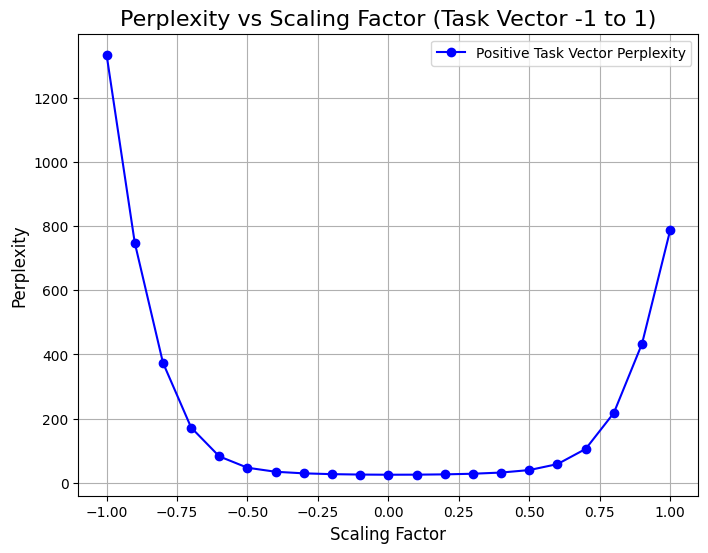

In [65]:
"""visaulize ppl"""
import matplotlib.pyplot as plt

# Assuming 'ppl_results' and 'neg_ppl_results' contain tuples of (scale, perplexity)
# Example format: [(scale_1, ppl_1), (scale_2, ppl_2), ..., (scale_n, ppl_n)]

# Unpack scaling factors and perplexities for both positive and negative task vectors
scaling_factors_pos, perplexities_pos = zip(*neg_to_pos_ppl_results)
#scaling_factors_neg, perplexities_neg = zip(*neg_ppl_results)

# Create the plot
plt.figure(figsize=(8, 6))

# Plot positive task vector perplexities
plt.plot(scaling_factors_pos, perplexities_pos, marker='o', color='b', label="Positive Task Vector Perplexity")

# Plot negative task vector perplexities
#plt.plot(scaling_factors_neg, perplexities_neg, marker='x', color='r', label="Negative Task Vector Perplexity")

# Set titles and labels
plt.title("Perplexity vs Scaling Factor (Task Vector -1 to 1)", fontsize=16)
plt.xlabel("Scaling Factor", fontsize=12)
plt.ylabel("Perplexity", fontsize=12)

# Optionally, add a grid for better readability
plt.grid(True)

# Show the legend
plt.legend()

# Display the plot
plt.show()
